# Toy Example

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(root))

%load_ext autoreload
%autoreload 2

## Import Packages

In [2]:
# Data
from survae.data.datasets.toy import CheckerboardDataset
from torch.utils.data import DataLoader

# Model
import torch
import torch.nn as nn
from survae.flows import Flow
from survae.distributions import StandardNormal
from survae.transforms import AffineCouplingBijection, ActNormBijection, Reverse
from survae.nn.layers import ElementwiseParams

# Optim
from torch.optim import Adam

# Plot
import matplotlib.pyplot as plt

## Data

In [3]:
train = CheckerboardDataset(num_points=128*1000)
test = CheckerboardDataset(num_points=128*1000)
train_loader = DataLoader(train, batch_size=128, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=True)

## MarkDown

In [15]:
def net(n_features):
  return nn.Sequential(nn.Linear(1, 200), nn.ReLU(),
                       nn.Linear(200, 100), nn.ReLU(),
                       nn.Linear(100, n_features), ElementwiseParams(n_features))

model = Flow(base_dist=StandardNormal((2,)),
             transforms=[
               AffineCouplingBijection(net(2)), ActNormBijection(2), Reverse(2),
               AffineCouplingBijection(net(2)), ActNormBijection(2), Reverse(2),
               AffineCouplingBijection(net(2)), ActNormBijection(2), Reverse(2),
               AffineCouplingBijection(net(2)), ActNormBijection(2),
             ])


### Demo Data

In [25]:
test_x = train[:1_000]

In [26]:
loss = model.log_prob(test_x)


In [27]:
z, ldj = model.forward_transform(test_x)
x_approx = model.inverse_transform(z)



In [28]:
torch.testing.assert_allclose(test_x, x_approx)

In [29]:
import corner

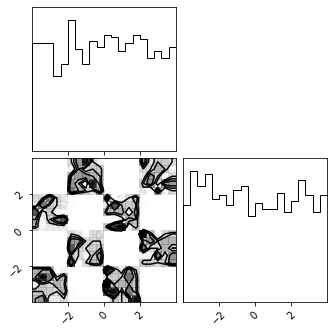

In [30]:
fig = corner.corner(test_x.detach().numpy())

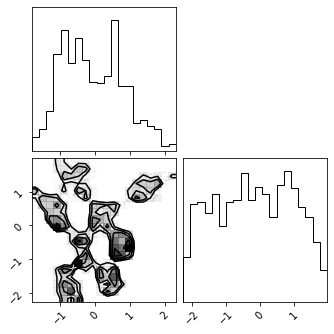

In [32]:
fig = corner.corner(z.detach().numpy())

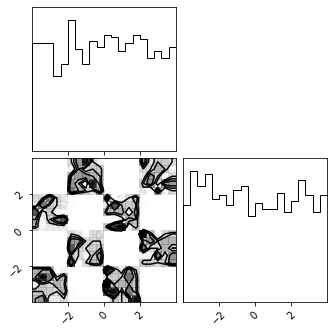

In [33]:
fig = corner.corner(x_approx.detach().numpy())